### Extended version of https://github.com/fastai/minai/blob/main/tutorial_01.ipynb

In [38]:

# Imports
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import transforms
from torch.optim import lr_scheduler

from miniai.datasets import *   # DataLoaders
from miniai.learner import *    # TrainCB, ...
from miniai.activations import * # ActivationStats
from miniai.accel import *      # AccelerateCB
from miniai.init import *       # GeneralRelu
from miniai.augment import *    # summary
from miniai.sgd import *        # BatchSchedCB, RecorderCB
from miniai.resnet import *        # ResBlock
import fastcore.all as fc
# import minai as mi # So we can see what is from minai in this tutorial
# from minai import *

from datasets import load_dataset
# from torchvision import datasets
from torcheval.metrics import  MulticlassAccuracy
from functools import partial
import matplotlib.pyplot as plt
# from fastai.vision.all import *

In [58]:
# import matplotlib as mpl
# mpl.rcParams['figure.constrained_layout.use'] = True

In [2]:
import numpy as np
import random
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

set_seed(1234, deterministic=True)

In [4]:
imagenet_data = torchvision.datasets.MNIST('../data/MNIST/', download=True)
data_loader = torch.utils.data.DataLoader(imagenet_data,batch_size=4,shuffle=True)
# TODO: How to use it?

### MINIAI local dataloaders

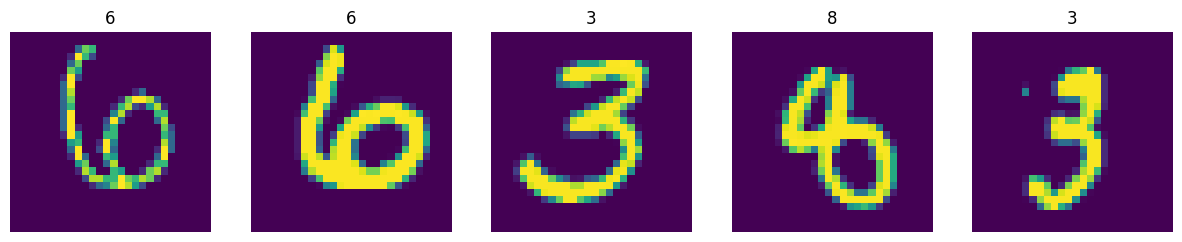

In [3]:
# Load a dataset from HF
dataset = load_dataset('mnist')

# Specify transforms
def transform(b):
    b['image'] = [TF.to_tensor(o) for o in b['image']]
    return b
dataset = dataset.with_transform(transform)

# Turn it into dls
dls = DataLoaders.from_dd(dataset,batch_size=64) 
# TODO: module 'minai' has no attribute 'DataLoaders'

# Look at the data
xb, yb = next(iter(dls.train))
xb.shape, yb.shape, yb[:5]
# The library has some useful utility functions such as:
show_images(xb[:5], ncols=5, titles=list(yb[:5].numpy()))

### FastAI dataloaders

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
print(path.ls())

files = get_image_files(path/"training")
print(len(files))

[Path('/home/alexander/.fastai/data/mnist_png/training'), Path('/home/alexander/.fastai/data/mnist_png/testing')]
60000


/home/alexander/Documents/Programming/Guidelines/.venv/lib/python3.10/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


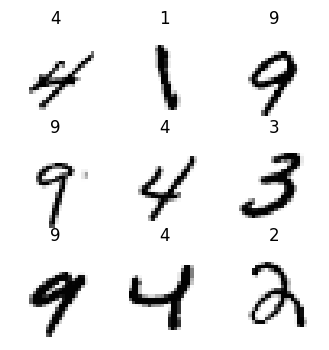

In [4]:

def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()
dls.show_batch(max_n=9, figsize=(4,4))

### Build Model

In [4]:

model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten()
)
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): AdaptiveAvgPool2d(output_size=1)
  (7): Flatten(start_dim=1, end_dim=-1)
)

In [20]:
import timm
model = timm.create_model('resnet18d', in_chans=1, num_classes=10)

In [ ]:
from timm.models.resnet import BasicBlock, ResNet, Bottleneck
model = ResNet(in_chans=1, block=BasicBlock, layers=[2,2,2,2], stem_width=32, avg_down=True)

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
#     res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
#     if act: res = nn.Sequential(res, act())
#     return res
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

# def get_model(act=nn.ReLU, nfs=None):
#     if nfs is None: nfs = [1,8,16,32,64]
#     layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
#     return nn.Sequential(*layers, conv(nfs[-1],10, act=None), nn.Flatten()).to(device)

# def get_model(act=nn.ReLU, nfs=None, norm=None):
#     if nfs is None: nfs = [1,8,16,32,64]
#     layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
#     return nn.Sequential(*layers, 
#                          conv(nfs[-1],10, act=None, norm=False, bias=True),
#                          nn.Flatten()).to(device)

# def get_model(act=nn.ReLU, nfs=(8,16,32,64,128), norm=nn.BatchNorm2d): # add more deep layer
#     layers = [conv(1, 8, stride=1, act=act, norm=norm)]
#     layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
#     return nn.Sequential(*layers, 
#                          conv(nfs[-1], 10, act=None, norm=norm, bias=True), 
#                          nn.Flatten()).to(device)
    
# def get_model(act=nn.ReLU, nfs=(8,16,32,64,128,256), norm=nn.BatchNorm2d): # ResNet works only for 28x28 cause of Flatten layer
#     layers = [ResBlock(1, 8, stride=1, act=act, norm=norm)]
#     layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
#     layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
#     return nn.Sequential(*layers).to(device)

# class GlobalAvgPool(nn.Module):
#     def forward(self, x): return x.mean((-2,-1))
# def get_model(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d): # Larger kernel without Flatten
#     layers = [conv(1, 16, ks=5, stride=1, act=act, norm=norm)]
#     layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
#     layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
#     return nn.Sequential(*layers).to(device)

class Dropout(nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p
    def forward(self, x):
        if not self.training: return x
        dist = torch.distributions.binomial.Binomial(torch.tensor(1.0).to(x.device), probs=1-self.p)
        return x * dist.sample(x.size()) * 1/(1-self.p)
def get_model(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d, drop=0.1): # Add Dropout
    layers = [conv(1, 16, ks=5, stride=1, act=act, norm=norm), nn.Dropout2d(drop)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), Dropout(drop), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(device)

def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): nn.init.kaiming_normal_(m.weight, a=leaky)

In [26]:
model = get_model()
model

Sequential(
  (0): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (idconv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1))
    )
    (act): ReLU()
  )
  (1): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, m

### Set Parameters

In [39]:
def _lr(cb): return cb.pg['lr']
def _beta1(cb): return cb.pg['betas'][0]
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

epochs = 1
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=epochs * len(dls.train))
# astats = ActivationStats(fc.risinstance(nn.Conv2d))
astats = ActivationStats(fc.risinstance(GeneralRelu))
rec = RecorderCB(lr=_lr)
# rec = RecorderCB(lr=_lr, mom=_beta1), # Saves to rec learning rate and momentum of the optimizer

tfms = nn.Sequential(transforms.RandomCrop(28, padding=4),
                     transforms.RandomHorizontalFlip(),
                     RandErase(),
                     RandCopy())
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True) # Image augmentation
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=True) # Image augmentation
# There are callbacks for all sorts of things, here are some common ones:
cbs = [
    # TrainCB(), # Handles the core steps in the training loop. Can be left out if using TrainLearner
    # MixedPrecision(), # accelerated version of TrainCB
    DeviceCB(), # Handles making sure data and model are on the right device
    MetricsCB(accuracy=MulticlassAccuracy()), # Keep track of any relevant metrics
    ProgressCB(plot=True), # Displays metrics and loss during training, optionally plot=True for a pretty graph
    BatchSchedCB(sched), # 
    rec,
    astats,
    # augcb,
    # ttacb,
]

# Nothing fancy for the loss function
loss_fn = nn.CrossEntropyLoss()
# loss_fn = F.cross_entropy # Не работает

# Specify a custom learning rate and optimizer
# opt_func = partial(torch.optim.Adam, weight_decay=1e-5)
opt_func = torch.optim.AdamW

# The learner takes a model, dataloaders and loss function, plus some optional extras like a list of callbacks
# learn = Learner(model, dls, loss_fn, lr=0.1, cbs=cbs)
# learn = TrainLearner(model, dls, loss_fn, lr=0.1, cbs=cbs, opt_func=opt_func)
# learn = MomentumLearner(model, dls, loss_fn, lr=0.1, cbs=cbs, opt_func=opt_func)

# And fit does the magic :)
# learn.fit(1)

In [42]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4, maxv=5)
iw = partial(init_weights, leaky=0.1)

model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw) # Comment if needed
learn = MomentumLearner(model, dls, loss_fn, lr=0.1, cbs=cbs, opt_func=opt_func)
learn.summary() # worked only for get_model()

Tot params: 4901108; MFLOPS: 17.0


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Sequential|(64, 1, 28, 28)|(64, 16, 28, 28)|448|0.3|
|Dropout2d|(64, 16, 28, 28)|(64, 16, 28, 28)|0|0.0|
|ResBlock|(64, 16, 28, 28)|(64, 32, 14, 14)|14560|2.8|
|ResBlock|(64, 32, 14, 14)|(64, 64, 7, 7)|57792|2.8|
|ResBlock|(64, 64, 7, 7)|(64, 128, 4, 4)|230272|3.7|
|ResBlock|(64, 128, 4, 4)|(64, 256, 2, 2)|919296|3.7|
|ResBlock|(64, 256, 2, 2)|(64, 512, 1, 1)|3673600|3.7|
|Flatten|(64, 512, 1, 1)|(64, 512)|0|0.0|
|Dropout|(64, 512)|(64, 512)|0|0.0|
|Linear|(64, 512)|(64, 10)|5120|0.0|
|BatchNorm1d|(64, 10)|(64, 10)|20|0.0|


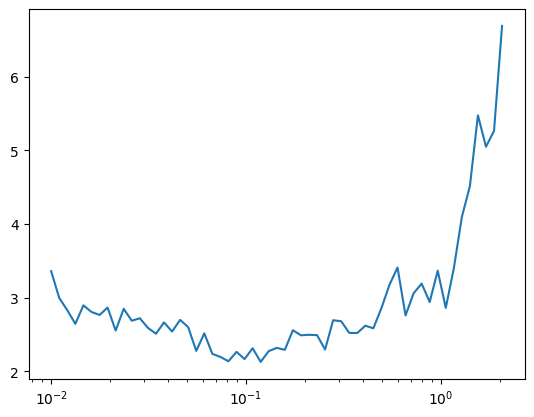

In [29]:
learn.lr_find()
# learn.lr_find(gamma=1.1, start_lr=1e-2)

accuracy,loss,epoch,train
0.570,1.299,0,train
0.890,0.397,0,eval


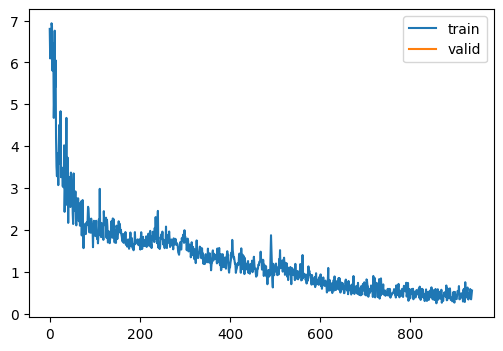

In [30]:
learn.fit(epochs)

### Statistics

In [31]:
xmean,xstd = xb.mean(),xb.std()
xmean,xstd

(tensor(0.1332), tensor(0.3100))

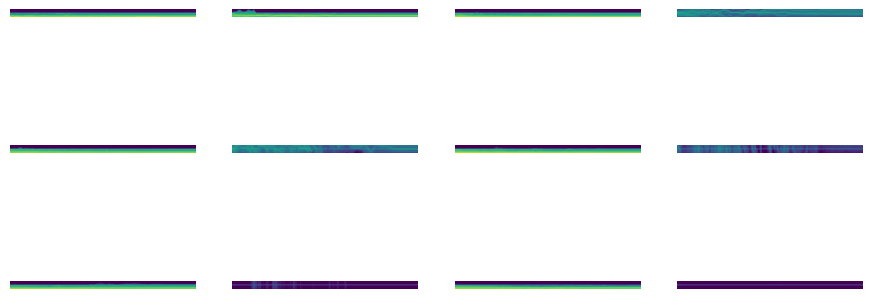

In [32]:
# plt.rc('image', cmap='viridis')
astats.color_dim()

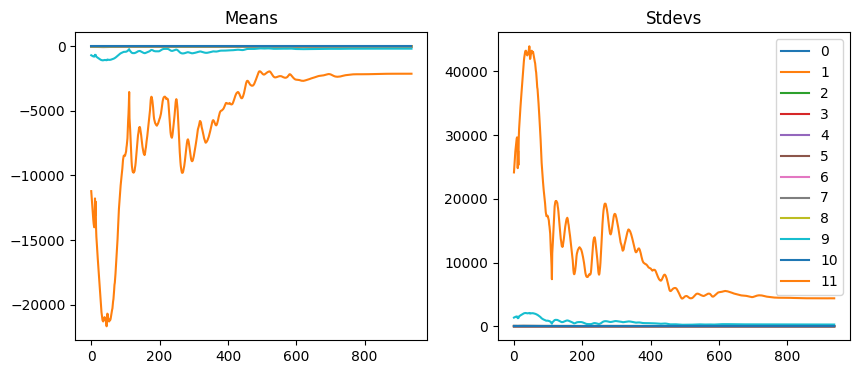

In [33]:
astats.plot_stats()

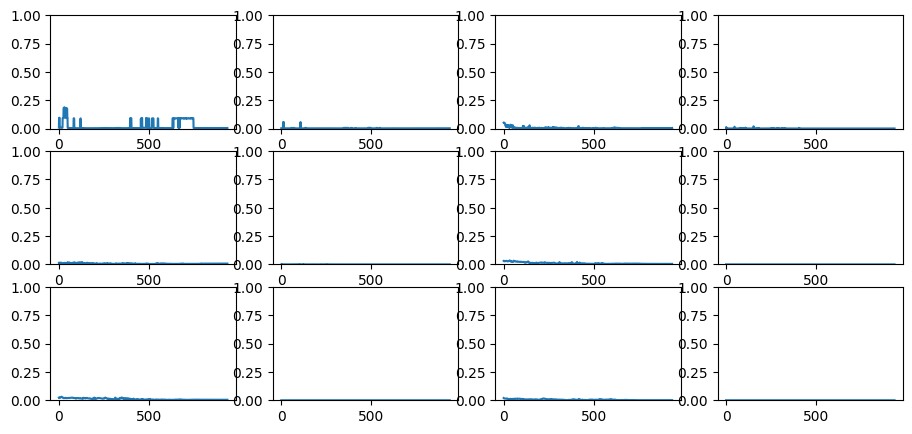

In [34]:
astats.dead_chart()

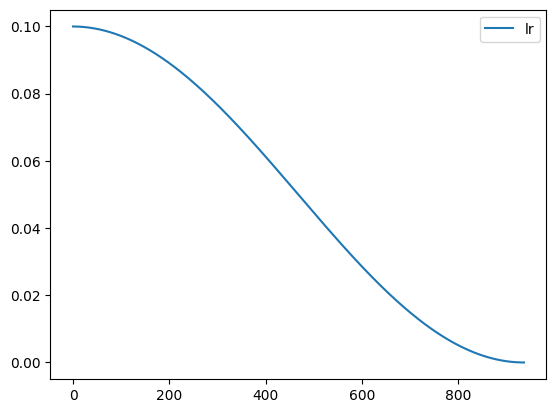

In [35]:
rec.plot()

In [63]:
clean_mem()